## Imports & Function

In [1]:
import matplotlib.pyplot as plt
import json
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister, assemble
from qiskit_aer import Aer, AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2, Session, SamplerOptions
from qtcodes import XXZZQubit
import time
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import mode
import logging
import asyncio
import pickle
import qiskit.qpy as qpy
from concurrent.futures import ThreadPoolExecutor, as_completed
import argparse

In [2]:
global api_token, service, backends
api_token = 'be5e713d2a8fa9228e96fbb61a84af3337e4730a2d7a174eaeeb8c625f964b516a29f367490a0fa50ec5de4dff1be879e018c6f87e906a15b379519049c9868a'

In [25]:
service = QiskitRuntimeService(
    channel="ibm_quantum",
    token=api_token,
    #instance="ibm-q-education/columbia-uni-2/computer-science"
)

In [26]:
service.backends()

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyiv')>,
 <IBMBackend('ibm_sherbrooke')>,
 <IBMBackend('ibmq_lima')>]

In [3]:
service = QiskitRuntimeService(channel="ibm_quantum", token=api_token)

In [10]:
backends =  service.backends()[:-1]

In [7]:
backends

<IBMBackend('ibm_kyiv')>

In [28]:
import json
import os

def convert_hex_to_binary_with_count(hex_str):
    # Convert hex to binary, remove the '0x' prefix
    binary_str = bin(int(hex_str, 16))[2:]
    # If the binary string exceeds 73 bits, truncate from the left
    if len(binary_str) > 73:
        binary_str = binary_str[-73:]
    else:
        # Otherwise, zero-pad to 73 bits
        binary_str = binary_str.zfill(73)
    
    # Format as readout, round1, round2, round3
    readout_value = binary_str[0]
    round1 = binary_str[1:25]
    round2 = binary_str[25:49]
    round3 = binary_str[49:]
    # Return formatted string
    return f"{readout_value} {round1} {round2} {round3}"

def process_json_files(input_folder, output_file):
    # Initialize a dictionary to collect all results organized by filename
    all_results = {}

    # Iterate over all JSON files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith('.json'):
            file_path = os.path.join(input_folder, filename)
            with open(file_path, 'r') as file:
                data = json.load(file)

            # Create an entry in the results dictionary for this file
            file_results = {}

            # Navigate to the counts dictionary within results
            if 'results' in data and isinstance(data['results'], list):
                for result in data['results']:
                    if 'data' in result and 'counts' in result['data']:
                        counts = result['data']['counts']
                        
                        # Process each hex value
                        for hex_str, count in counts.items():
                            if count == 1:  # Ensure count is 1 as per your specification
                                binary_format = convert_hex_to_binary_with_count(hex_str)
                                file_results[binary_format] = count
            
            # Store results under the filename key (without .json extension)
            all_results[filename.split('.')[0]] = file_results
    
    # Write collected results to the output JSON file
    with open(output_file, 'w') as outfile:
        json.dump(all_results, outfile, indent=2)

input_folder = 'hex_data'  # Folder containing your JSON files
output_file = 'brisbane_20241101.json'               # Output file to save the modified data
process_json_files(input_folder, output_file)

In [ ]:
import argparse
import logging

# Define the list of available backends
available_backends = ['backend1', 'backend2', 'backend3']  # Replace with actual backend names

def run_circ(qubit_name, backends):
    # Placeholder function for running the quantum circuit
    logging.info(f"Running circuit on qubit {qubit_name} with backends {backends}")

def main(qubit_name, backends):
    # Ensure logging is set up
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
  
    # Run the circuit with the given qubit and filtered backends
    run_circ(qubit_name, backends)

if __name__ == "__main__":
    # Set up argument parsing for the qubit name and backends
    parser = argparse.ArgumentParser(description="Run quantum circuit on multiple backends with specified mappings.")
    parser.add_argument("qubit_name", type=str, help="Name of the qubit (used to load/save files).")
    parser.add_argument("--backends", nargs="*", type=str, help="Space-separated list of backends to use (optional).")

    args = parser.parse_args()

    # Filter available backends based on user input, if provided
    if args.backends:
        backends = [backend.name for backend in backends if backend.name in args.backends]
    else:
        backends = available_backends

    main(args.qubit_name, backends)


In [12]:
args = 'ibm_brisbane'

In [14]:
[backend.name for backend in backends if backend.name in args]

['ibm_brisbane']

Check backend statuses: https://quantum.ibm.com/services/resources

Data Structure:
- 9 data qubits, 4 Z measurement qubits, 4 X measurement qubits, 1 readout value
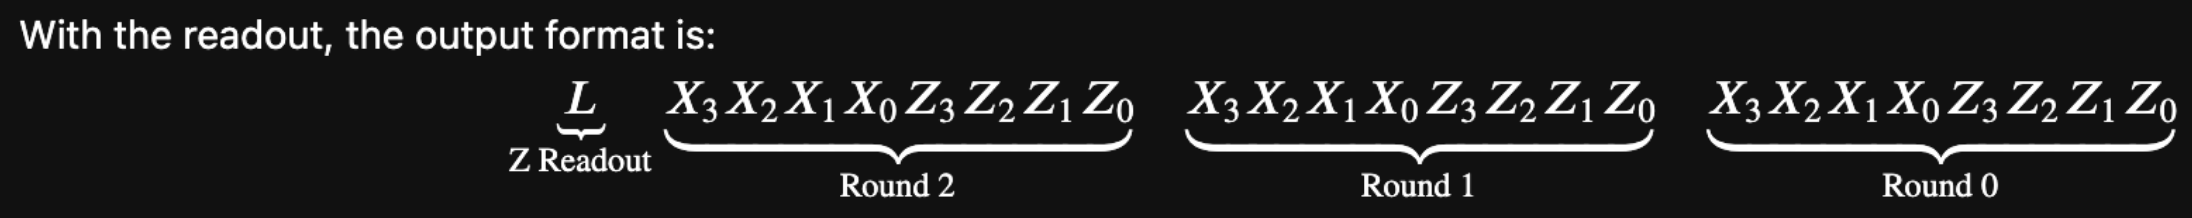

## Circuits

- For d=3: d^2 = 9 data, 4 X measure, 4 Z measure = 17 total qubits
- For d=5: d^2 = 25 data, 12 X measure, 12 Z measure = 49 total qubits

In [16]:
import json

def txt_to_json(file_path, output_path):
    data = {}
    
    # Open and read the text file
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
        # Process each line
        for line in lines:
            # Remove whitespace and trailing commas
            line = line.strip().rstrip(',')
            
            # Split at the first colon to separate the key and dictionary content
            if ': ' in line:
                key, values_str = line.split(': ', 1)
                key = key.strip()
                
                # Convert the string representation of the dictionary to a real dictionary
                values_dict = eval(values_str)  # Caution: eval() should only be used if you trust the file's content
                
                # Add to data dictionary
                data[key] = values_dict
    
    # Write the dictionary to a JSON file
    with open(output_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)
    print(f"Data successfully saved to {output_path}")

# Usage example:
txt_to_json('qubit_d5_drift_sherbrooke_day2.txt', 'data/qubit_d5_drift_sherbrooke_20241101.json')

Data successfully saved to data/qubit_d5_drift_sherbrooke_20241101.json


In [29]:
import json
import os

def concatenate_json_files(folder_path, output_file):
    concatenated_data = {}

    # Loop through all files in the specified folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            
            # Open and load each JSON file
            with open(file_path, 'r') as json_file:
                data = json.load(json_file)
                
                # Concatenate the contents
                concatenated_data.update(data)
    
    # Write the concatenated data to the output JSON file
    with open(output_file, 'w') as output_json_file:
        json.dump(concatenated_data, output_json_file, indent=4)
    
    print(f"All JSON files in '{folder_path}' have been concatenated and saved to '{output_file}'")

concatenate_json_files('data/drift_results', 'data/drift_results/combined_results.json')

All JSON files in 'data/drift_results' have been concatenated and saved to 'data/drift_results/combined_results.json'


In [9]:
def run_on_backend(qubit, backend):
    result = {}
    qpy_file = f'data/{qubit.name}_{backend.name}.qpy'
    
    try:
        logging.info(f'*Backend: {backend.name}')
        
        if os.path.exists(qpy_file):
            # Load the existing transpiled circuit from QPY file
            logging.info(f'*\tLoading existing QPY file: {qpy_file}')
            with open(qpy_file, 'rb') as qpy_f:
                qc = qpy.load(qpy_f)[0]  # Load and take the first circuit from the QPY file    
        else:
            # Transpile and save the new QPY file 
            logging.info(f'*\tTranspiling circuit for backend: {backend.name}')
            qc = transpile(qubit.circ, backend, optimization_level=0)  # Set optimization level to 0
            logging.info('\t\tTranspilation complete')

            with open(qpy_file, 'wb') as qpy_f:
                qpy.dump(qc, qpy_f)
            logging.info(f'*\t\tSaved transpiled circuit to {qpy_file}')

        # Prepare backend mapping for three different layouts
        backend_mapping = {}
        for mapping_label in ["A", "B", "C"]:     
            layout_file = f'data/{qubit.name}_{backend.name}_{mapping_label}_layout.json' 
            
            # Load existing layout if it exists, else create a new random layout
            if os.path.exists(layout_file):
                with open(layout_file, 'r') as layout_f:
                    backend_mapping = json.load(layout_f)
                    logging.info(f'*\tLoaded existing backend layouts from {layout_file}')
            else:
                # Generate a random layout for the new transpilation
                random_layout = np.random.permutation(backend.num_qubits)[:qc.num_qubits]
                backend_mapping[backend.name] = random_layout.tolist()
                logging.info(f'*\tGenerated random layout for {backend.name}: {random_layout}')

                # Save backend mappings (layouts) to the JSON file
                with open(layout_file, 'w') as layout_f:
                    json.dump(backend_mapping, layout_f, indent=4)
                logging.info(f'*\tSaved backend layouts to {layout_file}')

            # Use the layout (existing or newly generated) for transpilation
            qc_mapped = transpile(qc, backend, initial_layout=backend_mapping[backend.name], optimization_level=0)
            logging.info(f'*\tRunning job with mapping {mapping_label}...')

            # Run the job on the backend
            job = backend.run(qc_mapped, memory=True, shots=5000, job_tags=[f"{qubit.name}_{backend.name}_{mapping_label}"])
            result_counts = job.result().get_counts()
            logging.info(f'*\t\tGot results for mapping {mapping_label}!')

            # Store result counts in the dictionary
            result[f"{backend.name}_{mapping_label}"] = result_counts
            logging.info(f'*\t\tStored result for {backend.name} with mapping {mapping_label}')

    except Exception as e:
        logging.error(f'Error while running on backend {backend.name}: {str(e)}')

    return result

def run_circ(qubit_name, backends):
    # Load the qubit object from the pickle file
    pkl_file = f'data/{qubit_name}.pkl'
    try:
        with open(pkl_file, 'rb') as f:
            qubit = pickle.load(f)
        logging.info(f'*Loaded qubit: {qubit.name} from {pkl_file}')
    except Exception as e:
        logging.error(f"Failed to load qubit from {pkl_file}: {e}")
        return

    results = {}
    # Open a backup file to write results incrementally
    with open(f'{qubit.name}_backup.txt', 'a') as backup_file:

        # Use ThreadPoolExecutor to run the function on each backend concurrently
        with ThreadPoolExecutor() as executor:
            futures = {executor.submit(run_on_backend, qubit, backend): backend for backend in backends}
            for future in as_completed(futures):
                backend = futures[future]
                try:
                    result = future.result()
                    if result:
                        results.update(result)
                        # Write the result to the backup file immediately
                        for mapping_label in ["A", "B", "C"]:
                            if f"{backend.name}_{mapping_label}" in result:
                                backup_file.write(f'{backend.name}_{mapping_label}: {result[f"{backend.name}_{mapping_label}"]}\n')
                        backup_file.flush()
                        logging.info(f'*Backup stored for {backend.name}')
                except Exception as e:
                    logging.error(f'Error while processing {backend.name}: {e}')

    # After processing all backends, write the results to the JSON file
    with open(f'{qubit.name}_results.json', 'w') as f:
        json.dump(results, f, indent=4)
    logging.info(f'*Stored results in: {qubit.name}_results.json')

In [ ]:
name = 'qubit_d5_drift'
run_circ(name, backends)

ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/devon/anaconda3/lib/python3.11/site-packages/qiskit/__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/devon/anaconda3/lib/python3.11/site-packages/qiskit/__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/devon/anaconda3/lib/python3.11/site-packages/qiskit/__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/devon/anaconda3/lib/python3.11/site-packages/qiskit/__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/devon/anaconda3/lib/python3.11/site-packages/qiskit/__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qisk

Circuit updates:
- pkl file created
- Times of transpilation:
    - same day as pkl creation (1)
    - one day out (2)
    - one week out (3)
- Trivial optimization
    - Optimization level 0
- Three mappings of the same circuit
    - Set the mapping explcitly
    - Set initial layout for mapping A
    - Mappings B & C are permutations of mapping A
```python
for backend in backends:
    for mapping_label in ["a", "b", "c"]:
        random_layout = np.random.permutation(backend.num_qubits)[
            : qc.num_qubits
        ]
        qc_transpiled = transpile(qc, backend, initial_layout=random_layout)
```

In [ ]:
def main(qubit_name, backends):
    # Ensure logging is set up
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
  
    # Run the circuit with the given qubit and backends
    run_circ(qubit_name, backends)

if __name__ == "__main__":
    # Set up argument parsing for the qubit name
    parser = argparse.ArgumentParser(description="Run quantum circuit on multiple backends with specified mappings.")
    parser.add_argument("qubit_name", type=str, help="Name of the qubit (used to load/save files).")
    args = parser.parse_args()
    main(args.qubit_name, backends)

In [9]:
name = 'qubit_d5_drift'
qubit_d5_drift = XXZZQubit({'d': 5}, name=name)
qubit_d5_drift.stabilize()
qubit_d5_drift.x()
qubit_d5_drift.stabilize()
qubit_d5_drift.x()
qubit_d5_drift.stabilize()
qubit_d5_drift.readout_z()

with open(f'data/{name}.pkl', 'wb') as f:
    pickle.dump(qubit_d5_drift, f)

### Old Work

In [16]:
with open('qubit1Z_d3_b_results2.json', 'a') as json_file:
    json.dump(data, json_file, indent=4)

In [ ]:
results

In [ ]:
name = 'qubit1Z_d3_b_state'
run_circ(f'data/{name}.pkl', f'data/{name}.qpy', backends)

In [7]:
for job in service.jobs():
    print(job.status().name, job.tags)

DONE ['qubit_d5_drift_ibm_brisbane_A']
DONE ['qubit_d5_drift_ibm_sherbrooke_A']
QUEUED ['qubit_d5_drift_ibm_kyiv_A']
DONE ['qubit_d5_drift_ibm_sherbrooke_C']
DONE ['qubit_d5_drift_ibm_sherbrooke_B']
DONE ['qubit_d5_drift_ibm_brisbane_B']
DONE ['qubit_d5_drift_ibm_sherbrooke_A']
CANCELLED ['qubit_d5_drift_ibm_kyiv_A']
DONE ['qubit_d5_drift_ibm_brisbane_A']
CANCELLED ['qubit_d5_drift_ibm_brisbane_A']


In [ ]:
def cancel_pending_jobs():
    for job in service.jobs():
        print(job.status().name)
        if job.status().name in ["QUEUED", "RUNNING"]:
            print(f"\tCancelling job {job.job_id()}")
            job.cancel()

In [ ]:
cancel_pending_jobs()

ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/devon/anaconda3/lib/python3.11/site-packages/qiskit/__init__.py)
/var/folders/k3/27w60qks2nn1dv0q05k_30z40000gn/T/ipykernel_46067/1681029668.py:16: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  job = backend.run(qc_mapped, memory=True, shots=5000, job_tags=[f"{qubit.name}_{backend.name}_{mapping_label}"])
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'extensions' from 'qiskit' (/Users/devon/anaconda3/lib/python3.11/site-packages/qiskit/__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'extensions' from 'qiskit' (/Users/devon/anaconda3/lib/python3.11